# Build Simulated Catalog

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy import stats
from   scipy.interpolate import interp1d
import csv
import sys
import os
import importlib as imp

sys.path.insert(0, "./forecaster/")
import mr_forecast as mr


import alderaan.io as io
from alderaan.constants import *
from alderaan.utils import *

In [2]:
PRIMARY_DIR  = '/Users/research/projects/alderaan/'
CSV_IN  = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"
CSV_OUT = PRIMARY_DIR + "Catalogs/simulated_catalog_radius_valley.csv"

# Read in real KOI data and do some quick cleanup

In [3]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_IN)

# put these csv data into a dictionary
real_kois = {}
for k in csv_keys: 
    real_kois[k] = io.get_csv_data(k, csv_keys, csv_values)
    
k0 = "koi_id"
    
print("Loaded {0} real KOIs".format(len(real_kois[k0])))

Reading in data from csv file
Loaded 4297 real KOIs


In [4]:
# convert datatypes
for k in real_kois.keys():
    try:
        real_kois[k] = np.asarray(real_kois[k], dtype="float")
    except:
        real_kois[k] = np.asarray(real_kois[k])
    
    
real_kois["npl"] = np.asarray(real_kois["npl"], dtype="int")
real_kois["kic_id"] = np.asarray(real_kois["kic_id"], dtype="int")

In [5]:
# eliminate any KOIs with short period planets (P < 10 days)
usp_kics = []

for i, per in enumerate(real_kois["period"]):
    if per < 5.0:
        usp_kics.append(real_kois["kic_id"][i])
        

bad = np.isin(real_kois["kic_id"], usp_kics)


for k in real_kois.keys():
    real_kois[k] = real_kois[k][~bad]

In [6]:
# eliminate any NaN-valued systems
bad = np.zeros(len(real_kois["koi_id"]), dtype="bool")

for k in real_kois.keys():
    if real_kois[k].dtype == "float64":
        bad += np.isnan(real_kois[k])
        
        
for i, koi in enumerate(real_kois["koi_id"]):
    use = real_kois["koi_id"] == koi
    
    if np.sum(bad[use]) > 0:
        bad[use] = True
    
for k in real_kois.keys():
    real_kois[k] = real_kois[k][~bad]

In [7]:
# recalculate radius ratio to ensure consistency
real_kois["ror"] = real_kois["prad"]/real_kois["rstar"]/RSRE

In [8]:
real_kois.keys()

dict_keys(['planet_name', 'disposition', 'koi_id', 'kic_id', 'npl', 'kep_mag', 'mstar', 'mstar_err1', 'mstar_err2', 'rstar', 'rstar_err1', 'rstar_err2', 'logrho', 'logrho_err1', 'logrho_err2', 'Teff', 'Teff_err1', 'Teff_err2', 'FeH', 'FeH_err1', 'FeH_err2', 'logg', 'logg_err1', 'logg_err2', 'limbdark_1', 'limbdark_2', 'period', 'period_err1', 'period_err2', 'epoch', 'epoch_err1', 'epoch_err2', 'prad', 'prad_err1', 'prad_err2', 'impact', 'impact_err1', 'impact_err2', 'depth', 'depth_err1', 'depth_err2', 'duration', 'duration_err1', 'duration_err2', 'ror', 'ror_err1', 'ror_err2', 'dor', 'dor_err1', 'dor_err2', 'snr', 'num_transits'])

In [9]:
my_keys = ['planet_name', 'disposition', 'koi_id', 'kic_id', 
           'npl', 'kep_mag', 
           'mstar', 'mstar_err1', 'mstar_err2', 
           'rstar', 'rstar_err1', 'rstar_err2',
           'logrho', 'logrho_err1', 'logrho_err2',
           'limbdark_1', 'limbdark_2', 
           'pmass', 'prad', 'period', 'epoch', 'impact','ecc', 'omega', 
           'depth', 'duration', 'ror', 'dor',
           'snr', 'ttv_type']

# (1) Single planet systems

In [10]:
singles = {}

for k in my_keys:
    singles[k] = []
    

# draw single-planet systems and assign them a TTV type
use1 = (real_kois["npl"] == 1)*(real_kois["rstar"] < 1.5)*(real_kois["period"] < 300.)*(real_kois["ror"] < 0.05)
N1 = int(np.sum(use1))

print("{0} planets in single systems".format(N1))

select_systems = real_kois["koi_id"][use1]
np.random.shuffle(select_systems)

for i, ss in enumerate(select_systems):
    use = real_kois["koi_id"] == ss
    
    for k in singles.keys():
        if np.isin(k, list(real_kois.keys())):
            singles[k].append(real_kois[k][use][0])
    
    # assign TTV model
    if i < 0.25*N1:
        singles["ttv_type"].append("linear")
    elif i < 0.50*N1:
        singles["ttv_type"].append("quadratic")
    elif i < 0.75*N1:
        singles["ttv_type"].append("cubic")
    elif i < N1:
        singles["ttv_type"].append("sinusoidal")
        
for k in singles.keys():
    singles[k] = np.asarray(singles[k])

1233 planets in single systems


In [11]:
# shift epochs forward by 1/phi
singles["epoch"] += singles["period"]/1.618

# draw periods
singles["period"] = np.random.uniform(0., 30., size=N1)

# draw radii
small = singles["prad"] < 1.6

singles["prad"][small] = np.random.uniform(1.0, 1.5, size=np.sum(small))
singles["prad"][~small] = np.random.uniform(1.7, 2.3, size=np.sum(~small))

singles["ror"] = singles["prad"]/singles["rstar"]/RSRE

# set mass values to NaN
singles["pmass"] = ["nan"]*N1


# assign impact parameter
singles["impact"] = np.random.uniform(0., 1., size=N1)


# assign eccentricity vectors
singles["ecc"] = np.random.uniform(0, 0.9, size=len(singles["prad"]))
singles["omega"] = np.random.uniform(0, 2*pi, size=len(singles["prad"]))

# Fix dispositions and planet names to SIMULATED

In [12]:
my_catalog = {}

for k in my_keys:
    my_catalog[k] = singles[k]
    
my_catalog['disposition'] = np.array(["SIMULATED"]*len(my_catalog["disposition"]))

In [13]:
# fix planet names
for i, pname in enumerate(my_catalog["planet_name"]):
    my_catalog["planet_name"][i] = "S" + pname[1:]

# Perturb stellar masses and radii within uncertainties

In [14]:
for i, koi in enumerate(my_catalog["koi_id"]):
    use = my_catalog["koi_id"] == koi

    # perturb masses
    mstar = my_catalog["mstar"][use][0]
    mstar_err = np.sqrt(my_catalog["mstar_err1"][use][0]**2 + my_catalog["mstar_err2"][use][0]**2)/np.sqrt(2)

    my_catalog["mstar"][use] = mstar + mstar_err*stats.truncnorm.rvs(-3,3)
    
    if np.any(my_catalog["mstar"][use] < 0):
        my_catalog["mstar"][use] = mstar*np.random.uniform(0.95,1.05)*mstar

    
    # perturb radii
    rstar = my_catalog["rstar"][use][0]
    rstar_err = np.sqrt(my_catalog["rstar_err1"][use][0]**2 + my_catalog["rstar_err2"][use][0]**2)/np.sqrt(2)

    my_catalog["rstar"][use] = rstar + rstar_err*stats.truncnorm.rvs(-3,3)
    
    if np.any(my_catalog["rstar"][use] < 0):
        my_catalog["rstar"][use] = rstar*np.random.uniform(0.95,1.05)*rstar
    
    
my_catalog["logrho"] = np.log10(my_catalog["mstar"]/my_catalog["rstar"]**3*RHOSUN_GCM3)

# Recalculate transit depths, durations, $r_p/R_{\star}$, and $a/R_{\star}$

In [15]:
# recalculate transit depths and durations
my_catalog["depth"] = get_transit_depth(my_catalog["prad"]/my_catalog["rstar"]/RSRE, my_catalog["impact"])*1e6


# recalculate transit durations
sma = get_sma(my_catalog["period"], my_catalog["mstar"])

my_catalog["duration"] = 24*get_dur_tot(my_catalog["period"], 
                                        my_catalog["prad"]/RSRE, 
                                        my_catalog["rstar"],
                                        my_catalog["impact"],
                                        sma,
                                        my_catalog["ecc"],
                                        my_catalog["omega"])


my_catalog["ror"] = my_catalog["prad"]/my_catalog["rstar"]/RSRE
my_catalog["dor"] = sma/my_catalog["rstar"]

/Users/research/projects/alderaan/alderaan/utils.py:95: RuntimeWarning: invalid value encountered in arccos
  sini = np.sin(np.arccos(b/(sma/Rs)))
/Users/research/projects/alderaan/alderaan/utils.py:103: RuntimeWarning: invalid value encountered in arcsin
  Ttot = (P/pi)*np.arcsin(argument)*Xe


# Calculate SNR and remove systems hosting any planets with SNR < 7.1

In [16]:
# Read in CDPP data
cdpp = io.load_cdpp_data(PRIMARY_DIR + "Catalogs/keplerstellar_cdpp.csv")

# do some data cleanup
for k in cdpp.keys():
    cdpp[k] = np.asarray(cdpp[k])
    cdpp[k][cdpp[k] == ""] = "nan"

    
for k in cdpp.keys():
    try:
        cdpp[k] = np.asarray(cdpp[k], dtype="float")
    except:
        pass
    
cdpp["kepid"] = np.asarray(cdpp["kepid"], dtype="int")
cdpp["nkoi"]  = np.asarray(cdpp["nkoi"], dtype="int")


cdpp_interp = []
bad_dur = []

for i, kic in enumerate(my_catalog["kic_id"]):
    cdpp_dur, cdpp_rms = io.pull_cdpp_rms(cdpp, kic)
    
    tdur = my_catalog["duration"][i]
    
    if np.isnan(tdur):
        tdur = get_dur_tot(my_catalog["period"][i], my_catalog["prad"][i]/RSRE, my_catalog["rstar"][i],
                           my_catalog["impact"][i], get_sma(my_catalog["period"][i], my_catalog["mstar"][i]))
        
        bad_dur.append(True)
        
    else:
        bad_dur.append(False)
    
    cdpp_interp.append(interp1d(cdpp_dur, cdpp_rms, bounds_error=False, fill_value="extrapolate")(tdur))
    
    
cdpp_interp = np.squeeze(cdpp_interp)

In [17]:
# Read in occurence rate data products
keys, vals = io.read_csv_file(PRIMARY_DIR + "Catalogs/keplerstellar_occurence.csv")

occ = {}
for k in keys: 
    occ[k] = io.get_csv_data(k, keys, vals)

    
# do some data cleanup
for k in occ.keys():
    occ[k] = np.asarray(occ[k])
    occ[k][occ[k] == ""] = "nan"

    
for k in occ.keys():
    try:
        occ[k] = np.asarray(occ[k], dtype="float")
    except:
        pass
    
    
occ["kepid"] = np.asarray(occ["kepid"], dtype="int")
occ["nkoi"]  = np.asarray(occ["nkoi"], dtype="int")


dutycycle = []
dataspan = []

for i, kic in enumerate(my_catalog["kic_id"]):
    use = occ["kepid"] == kic
    
    loc = np.nanargmax(occ["dataspan"][use])
    dutycycle.append(occ["dutycycle"][use][loc])
    dataspan.append(occ["dataspan"][use][loc])
    
    
dutycycle = np.asarray(dutycycle)
dataspan = np.asarray(dataspan)

expected_num_transits = dataspan/my_catalog["period"]*dutycycle

In [18]:
# calculate snr
snr = my_catalog["depth"]/cdpp_interp * np.sqrt(expected_num_transits)
bad = snr < 7.1

# remove low SNR or NaN-valued objects
for k in my_catalog.keys():
    my_catalog[k] = np.asarray(my_catalog[k])
    
    try:
        bad += np.isnan(my_catalog[k])
    except:
        pass
    
    
for k in my_catalog.keys():
    my_catalog[k] = my_catalog[k][~bad]

### Resize mini-Neptune population count to match super-Earth population count

In [26]:
small = my_catalog["prad"] < 1.6

keep = np.random.choice(my_catalog["koi_id"][~small], size=np.sum(small), replace=False)
keep = np.hstack([keep, my_catalog["koi_id"][small]])
keep = np.isin(my_catalog["koi_id"], keep)

for k in my_catalog.keys():
    my_catalog[k] = my_catalog[k][keep]

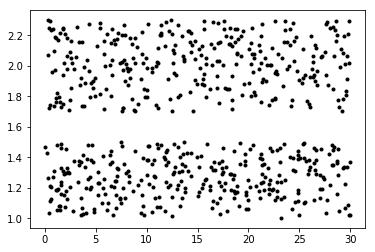

In [28]:
plt.figure()
plt.plot(my_catalog["period"], my_catalog["prad"], "k.")
plt.show()

# Do some cleanup

In [29]:
my_catalog.keys()

dict_keys(['planet_name', 'disposition', 'koi_id', 'kic_id', 'npl', 'kep_mag', 'mstar', 'mstar_err1', 'mstar_err2', 'rstar', 'rstar_err1', 'rstar_err2', 'logrho', 'logrho_err1', 'logrho_err2', 'limbdark_1', 'limbdark_2', 'pmass', 'prad', 'period', 'epoch', 'impact', 'ecc', 'omega', 'depth', 'duration', 'ror', 'dor', 'snr', 'ttv_type'])

In [30]:
all_keys = list(my_catalog.keys())
int_keys = ['kic_id', 'npl', 'depth']
string_keys = ['planet_name', 'disposition', 'koi_id', 'ttv_type']
precise_keys = ['period', 'epoch']


for k in my_catalog.keys():
    if np.isin(k, int_keys):
        my_catalog[k] = np.array(my_catalog[k], dtype="int")
    elif np.isin(k, string_keys):
        my_catalog[k] = my_catalog[k]
    elif np.isin(k, precise_keys):
        my_catalog[k] = np.round(np.array(my_catalog[k], dtype="float"), 5)
    else:
        my_catalog[k] = np.round(np.array(my_catalog[k], dtype="float"), 3)

# Write out the catalog

In [31]:
WRITENEW = True
if WRITENEW:
    with open(CSV_OUT, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(my_catalog.keys())
        writer.writerows(zip(*my_catalog.values()))